(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitUtils

import Revise
# Import project package
import BayesFitUtils

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase

# Import library to list files
import Glob

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Data Wrangling for Kinsler et al., 2020

In this notebook we will turn the raw barcode counts from the Kinsler et al.,
2020 eLife paper experiment into a tidy data frame. Let's begin by loading the
raw `.csv` file.

In [2]:
# Load CSV file
df = CSV.read("$(git_root())/data/kinsler_2020/bc_counts.csv", DF.DataFrame)

first(df, 5)

Row,1.4%-R1-T1,1.4%-R1-T2,1.4%-R1-T3,1.4%-R1-T4,1.4%-R2-T1,1.4%-R2-T2,1.4%-R2-T3,1.4%-R2-T4,1.4%-T0,1.5%-R1-T1,1.5%-R1-T2,1.5%-R1-T3,1.5%-R1-T4,1.5%-R2-T1,1.5%-R2-T2,1.5%-R2-T3,1.5%-R2-T4,1.5%-T0,1.6%-R1-T1,1.6%-R1-T2,1.6%-R1-T3,1.6%-R1-T4,1.6%-R2-T1,1.6%-R2-T2,1.6%-R2-T3,1.6%-R2-T4,1.6%-T0,1.7%-R1-T1,1.7%-R1-T2,1.7%-R1-T3,1.7%-R1-T4,1.7%-R2-T1,1.7%-R2-T2,1.7%-R2-T3,1.7%-R2-T4,1.7%-T0,1.8%-R1-T1,1.8%-R1-T2,1.8%-R1-T3,1.8%-R1-T4,1.8%-R2-T1,1.8%-R2-T2,1.8%-R2-T3,1.8%-R2-T4,1.8%-T0,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,13-3-3,13-4-1,13-4-2,13-4-3,18-1-1,18-1-2,18-1-3,18-2-1,18-2-2,18-2-3,18-3-1,18-3-2,18-3-3,18-4-1,18-4-2,18-4-3,2.5%-R1-T1,2.5%-R1-T2,2.5%-R1-T3,2.5%-R1-T4,2.5%-R2-T1,2.5%-R2-T2,2.5%-R2-T3,2.5%-R2-T4,2.5%-T0,20-1-1,20-1-2,20-1-3,20-2-1,20-2-2,20-2-3,20-3-1,20-3-2,20-3-3,20-4-1,20-4-2,20-4-3,21+wt,21-0-1,21-0-2,21-0-4,21-1-1,21-1-2,21-1-3,21-2-1,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,174.0,109.0,85.0,68.0,3.0,91.0,56.0,42.0,22.0,74.0,85.0,64.0,70.0,66.0,69.0,66.0,68.0,51.0,121.0,113.0,120.0,245.0,102.0,212.0,146.0,116.0,56.0,130.0,227.0,122.0,109.0,108.0,141.0,85.0,142.0,95.0,102.0,181.0,184.0,216.0,176.0,239.0,45.0,42.0,69.0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,361.0,51.0,70.0,59.0,90.0,133.0,122.0,40.0,65.0,481.0,365.0,102.0,574.0,486.0,516.0,380.0,27.0,19.0,17.0,24.0,10.0,11.0,7.0,6.0,20.0,773.0,2336.0,2192.0,2785.0,2493.0,2199.0,1855.0,1569.0,1775.0,954.0,1495.0,1990.0,0.0,3276.0,3105.0,3372.0,962.0,760.0,1889.0,1883.0,⋯
2,7374.0,18479.0,44673.0,96279.0,104.0,13081.0,26243.0,50295.0,629.0,2713.0,8975.0,19736.0,63889.0,2161.0,8175.0,19028.0,50199.0,1102.0,5096.0,13055.0,30405.0,141123.0,3330.0,17235.0,32195.0,65247.0,975.0,3784.0,15314.0,33243.0,34457.0,3473.0,8792.0,13059.0,80332.0,1314.0,3447.0,13525.0,32522.0,97939.0,6641.0,18834.0,7138.0,19516.0,1379.0,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,267212.0,223043.0,241795.0,145296.0,22844.0,14132.0,7847.0,6260.0,14745.0,66171.0,179028.0,49741.0,171156.0,491772.0,661420.0,367527.0,1017.0,810.0,1284.0,4544.0,211.0,612.0,670.0,2104.0,328.0,5215.0,14656.0,12802.0,26566.0,24995.0,21013.0,35823.0,31769.0,25010.0,34463.0,49171.0,41128.0,0.0,23186.0,22200.0,22599.0,14470.0,11899.0,27178.0,50457.0,⋯
3,461.0,256.0,200.0,152.0,3.0,271.0,117.0,65.0,118.0,196.0,177.0,122.0,112.0,140.0,203.0,131.0,119.0,165.0,421.0,267.0,254.0,419.0,261.0,508.0,288.0,236.0,160.0,330.0,460.0,227.0,243.0,325.0,278.0,137.0,336.0,302.0,286.0,423.0,425.0,426.0,471.0,549.0,69.0,97.0,268.0,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,1036.0,195.0,161.0,209.0,466.0,681.0,613.0,149.0,331.0,2356.0,1429.0,417.0,2165.0,1460.0,1711.0,1312.0,109.0,36.0,41.0,74.0,26.0,42.0,24.0,33.0,72.0,562.0,2189.0,2077.0,2223.0,2185.0,1772.0,1335.0,1225.0,1724.0,542.0,1056.0,1680.0,0.0,2938.0,2818.0,3181.0,701.0,437.0,1650.0,1422.0,⋯
4,4294.0,5325.0,6792.0,7633.0,57.0,4170.0,4132.0,4534.0,525.0,1546.0,2666.0,3129.0,5504.0,1437.0,2785.0,3453.0,5872.0,1019.0,3180.0,4374.0,5983.0,15873.0,2385.0,6422.0,6826.0,8019.0,842.0,2908.0,6319.0,5848.0,6153.0,2618.0,3807.0,3588.0,14075.0,1363.0,2399.0,6302.0,9329.0,17580.0,4586.0,8297.0,2010.0,3422.0,1377.0,710.0,1187.0,3

Let's begin by extracting the name of all non-metadata columns.

In [3]:
# List metadata columns
metadata_col = ["additional_muts", "barcode", "class", "gene", "ploidy", "type"]

# Extract dataset names
cond_names = DF.names(df[:, DF.Not(metadata_col)])

println("Number of column: $(length(cond_names))")

cond_names

Number of column: 340


340-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "Y1"
 "Y2"
 "Y3"
 "Y4"
 "Z0"
 "Z1"
 "Z2"
 "Z3"
 "Z4"

Next, let's extract the columns that already have the "right" format. This means
they are of the form `condition-R#-T#` or `condition-T0`. These columns, we can
easily parse when producing a tidy dataframe.

In [4]:
# Extract "correct names
correct_names = cond_names[occursin.("-T", cond_names)]

println("Number of correct columns: $(length(correct_names))")

correct_names

Number of correct columns: 81


81-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "Ben2-R1-T1"
 "Ben2-R1-T2"
 "Ben2-R1-T3"
 "Ben2-R1-T4"
 "Ben2-R2-T1"
 "Ben2-R2-T2"
 "Ben2-R2-T3"
 "Ben2-R2-T4"
 "Ben2-T0"

Deducing from the information the authors sent, we can map a few of the other
letter-based names to conditions. This is the list provided by the authors.

In [5]:
# Define the raw list sent by the authors on a Python Jupyter notebook
bigbatch_conditions = Dict(
    "M3" => ["A", "B", "C", "D"],
    "Baffle" => ["E", "F"],
    "1.4%Gluc" => ["G", "H"],
    "1.8%Gluc" => ["I", "J"],
    "0.2MNaCl" => ["K", "L"],
    "0.5MNaCl" => ["M", "N"],
    "0.2MKCl" => ["O"],
    "0.5MKCl" => ["P"],
    "8.5uMGdA" => ["Q", "R"],
    "17uMGdA" => ["S", "T"],
    "2ugFlu" => ["U", "V"],
    "0.5ugFlu" => ["W", "X"],
    "1%Raf" => ["Y", "Z"],
    "0.5%Raf" => ["AA", "BB"],
    "1%Gly" => ["CC", "DD"],
    "1%EtOH" => ["EE", "FF"],
    "SucRaf" => ["GG"],
)

Dict{String, Vector{String}} with 17 entries:
  "1%EtOH"   => ["EE", "FF"]
  "0.5ugFlu" => ["W", "X"]
  "M3"       => ["A", "B", "C", "D"]
  "0.5%Raf"  => ["AA", "BB"]
  "8.5uMGdA" => ["Q", "R"]
  "0.2MKCl"  => ["O"]
  "1%Gly"    => ["CC", "DD"]
  "1%Raf"    => ["Y", "Z"]
  "1.4%Gluc" => ["G", "H"]
  "Baffle"   => ["E", "F"]
  "0.5MNaCl" => ["M", "N"]
  "0.5MKCl"  => ["P"]
  "17uMGdA"  => ["S", "T"]
  "1.8%Gluc" => ["I", "J"]
  "SucRaf"   => ["GG"]
  "0.2MNaCl" => ["K", "L"]
  "2ugFlu"   => ["U", "V"]

Let's invert the dictionary to have the letters map to a condition and a
replicate number

In [6]:
# Initialize dictionary to save conditions
cond_dict = Dict()

# Loop through given conditions
for (key, item) in bigbatch_conditions
    # Merge dictionaries where each name gets a condition and a replica number
    merge!(
        cond_dict,
        Dict(["$(item[i])" => "$(key)-R$(i)" for i = 1:length(item)])
    )
end # for

cond_dict

Dict{Any, Any} with 33 entries:
  "Z"  => "1%Raf-R2"
  "Q"  => "8.5uMGdA-R1"
  "FF" => "1%EtOH-R2"
  "W"  => "0.5ugFlu-R1"
  "T"  => "17uMGdA-R2"
  "C"  => "M3-R3"
  "P"  => "0.5MKCl-R1"
  "K"  => "0.2MNaCl-R1"
  "V"  => "2ugFlu-R2"
  "CC" => "1%Gly-R1"
  "L"  => "0.2MNaCl-R2"
  "O"  => "0.2MKCl-R1"
  "BB" => "0.5%Raf-R2"
  "B"  => "M3-R2"
  "M"  => "0.5MNaCl-R1"
  "N"  => "0.5MNaCl-R2"
  "GG" => "SucRaf-R1"
  "H"  => "1.4%Gluc-R2"
  "A"  => "M3-R1"
  ⋮    => ⋮

The column names on the dataframe that match to either of these conditions must
have either two characters--a letter and a number specifying the time point--or
three characters--two letters and a number specifying the character--and start
with a letter. Let's extract those column names by these features.

In [7]:
# Extract column names by length and begining with string.
# NOTE: ^\D searches patterns whose first character is NOT a digit
len_names = cond_names[
    (length.(cond_names).≤3).&(match.(r"^\D", cond_names).!==nothing)
]

165-element Vector{String}:
 "A0"
 "A1"
 "A2"
 "A3"
 "A4"
 "AA0"
 "AA1"
 "AA2"
 "AA3"
 "AA4"
 ⋮
 "Y1"
 "Y2"
 "Y3"
 "Y4"
 "Z0"
 "Z1"
 "Z2"
 "Z3"
 "Z4"

Let's loop through these names and generate the corresponding "correct"
condition name.

In [8]:
# Initialize dictionary where to save correct names
letter_names_dict = Dict{String,String}()

# Loop through columns that satisfied condition
for i in len_names
    letter_names_dict[i] = "$(cond_dict[i[1:end-1]])-T$(i[end])"
end # for

letter_names_dict

Dict{String, String} with 165 entries:
  "O1"  => "0.2MKCl-R1-T1"
  "R2"  => "8.5uMGdA-R2-T2"
  "X1"  => "0.5ugFlu-R2-T1"
  "V3"  => "2ugFlu-R2-T3"
  "G4"  => "1.4%Gluc-R1-T4"
  "I4"  => "1.8%Gluc-R1-T4"
  "O4"  => "0.2MKCl-R1-T4"
  "BB3" => "0.5%Raf-R2-T3"
  "BB2" => "0.5%Raf-R2-T2"
  "N0"  => "0.5MNaCl-R2-T0"
  "U4"  => "2ugFlu-R1-T4"
  "T4"  => "17uMGdA-R2-T4"
  "CC4" => "1%Gly-R1-T4"
  "V1"  => "2ugFlu-R2-T1"
  "S4"  => "17uMGdA-R1-T4"
  "U2"  => "2ugFlu-R1-T2"
  "DD2" => "1%Gly-R2-T2"
  "G2"  => "1.4%Gluc-R1-T2"
  "Y0"  => "1%Raf-R1-T0"
  ⋮     => ⋮

We can now use this dictionary to rename the columns of the original dataframe.

In [9]:
# Rename dataframe columns
DF.rename!(df, letter_names_dict)

first(df, 5)

Row,1.4%-R1-T1,1.4%-R1-T2,1.4%-R1-T3,1.4%-R1-T4,1.4%-R2-T1,1.4%-R2-T2,1.4%-R2-T3,1.4%-R2-T4,1.4%-T0,1.5%-R1-T1,1.5%-R1-T2,1.5%-R1-T3,1.5%-R1-T4,1.5%-R2-T1,1.5%-R2-T2,1.5%-R2-T3,1.5%-R2-T4,1.5%-T0,1.6%-R1-T1,1.6%-R1-T2,1.6%-R1-T3,1.6%-R1-T4,1.6%-R2-T1,1.6%-R2-T2,1.6%-R2-T3,1.6%-R2-T4,1.6%-T0,1.7%-R1-T1,1.7%-R1-T2,1.7%-R1-T3,1.7%-R1-T4,1.7%-R2-T1,1.7%-R2-T2,1.7%-R2-T3,1.7%-R2-T4,1.7%-T0,1.8%-R1-T1,1.8%-R1-T2,1.8%-R1-T3,1.8%-R1-T4,1.8%-R2-T1,1.8%-R2-T2,1.8%-R2-T3,1.8%-R2-T4,1.8%-T0,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,13-3-3,13-4-1,13-4-2,13-4-3,18-1-1,18-1-2,18-1-3,18-2-1,18-2-2,18-2-3,18-3-1,18-3-2,18-3-3,18-4-1,18-4-2,18-4-3,2.5%-R1-T1,2.5%-R1-T2,2.5%-R1-T3,2.5%-R1-T4,2.5%-R2-T1,2.5%-R2-T2,2.5%-R2-T3,2.5%-R2-T4,2.5%-T0,20-1-1,20-1-2,20-1-3,20-2-1,20-2-2,20-2-3,20-3-1,20-3-2,20-3-3,20-4-1,20-4-2,20-4-3,21+wt,21-0-1,21-0-2,21-0-4,21-1-1,21-1-2,21-1-3,21-2-1,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,174.0,109.0,85.0,68.0,3.0,91.0,56.0,42.0,22.0,74.0,85.0,64.0,70.0,66.0,69.0,66.0,68.0,51.0,121.0,113.0,120.0,245.0,102.0,212.0,146.0,116.0,56.0,130.0,227.0,122.0,109.0,108.0,141.0,85.0,142.0,95.0,102.0,181.0,184.0,216.0,176.0,239.0,45.0,42.0,69.0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,361.0,51.0,70.0,59.0,90.0,133.0,122.0,40.0,65.0,481.0,365.0,102.0,574.0,486.0,516.0,380.0,27.0,19.0,17.0,24.0,10.0,11.0,7.0,6.0,20.0,773.0,2336.0,2192.0,2785.0,2493.0,2199.0,1855.0,1569.0,1775.0,954.0,1495.0,1990.0,0.0,3276.0,3105.0,3372.0,962.0,760.0,1889.0,1883.0,⋯
2,7374.0,18479.0,44673.0,96279.0,104.0,13081.0,26243.0,50295.0,629.0,2713.0,8975.0,19736.0,63889.0,2161.0,8175.0,19028.0,50199.0,1102.0,5096.0,13055.0,30405.0,141123.0,3330.0,17235.0,32195.0,65247.0,975.0,3784.0,15314.0,33243.0,34457.0,3473.0,8792.0,13059.0,80332.0,1314.0,3447.0,13525.0,32522.0,97939.0,6641.0,18834.0,7138.0,19516.0,1379.0,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,267212.0,223043.0,241795.0,145296.0,22844.0,14132.0,7847.0,6260.0,14745.0,66171.0,179028.0,49741.0,171156.0,491772.0,661420.0,367527.0,1017.0,810.0,1284.0,4544.0,211.0,612.0,670.0,2104.0,328.0,5215.0,14656.0,12802.0,26566.0,24995.0,21013.0,35823.0,31769.0,25010.0,34463.0,49171.0,41128.0,0.0,23186.0,22200.0,22599.0,14470.0,11899.0,27178.0,50457.0,⋯
3,461.0,256.0,200.0,152.0,3.0,271.0,117.0,65.0,118.0,196.0,177.0,122.0,112.0,140.0,203.0,131.0,119.0,165.0,421.0,267.0,254.0,419.0,261.0,508.0,288.0,236.0,160.0,330.0,460.0,227.0,243.0,325.0,278.0,137.0,336.0,302.0,286.0,423.0,425.0,426.0,471.0,549.0,69.0,97.0,268.0,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,1036.0,195.0,161.0,209.0,466.0,681.0,613.0,149.0,331.0,2356.0,1429.0,417.0,2165.0,1460.0,1711.0,1312.0,109.0,36.0,41.0,74.0,26.0,42.0,24.0,33.0,72.0,562.0,2189.0,2077.0,2223.0,2185.0,1772.0,1335.0,1225.0,1724.0,542.0,1056.0,1680.0,0.0,2938.0,2818.0,3181.0,701.0,437.0,1650.0,1422.0,⋯
4,4294.0,5325.0,6792.0,7633.0,57.0,4170.0,4132.0,4534.0,525.0,1546.0,2666.0,3129.0,5504.0,1437.0,2785.0,3453.0,5872.0,1019.0,3180.0,4374.0,5983.0,15873.0,2385.0,6422.0,6826.0,8019.0,842.0,2908.0,6319.0,5848.0,6153.0,2618.0,3807.0,3588.0,14075.0,1363.0,2399.0,6302.0,9329.0,17580.0,4586.0,8297.0,2010.0,3422.0,1377.0,710.0,1187.0,3

Again, let's search for the "correct columns" and count them.

In [10]:
# Extract dataset names
cond_names = DF.names(df[:, DF.Not(metadata_col)])

# Extract "correct" names
correct_names = cond_names[occursin.("-T", cond_names)]

println("Number of correct columns: $(length(correct_names))")

correct_names

Number of correct columns: 246


246-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "1%Raf-R1-T1"
 "1%Raf-R1-T2"
 "1%Raf-R1-T3"
 "1%Raf-R1-T4"
 "1%Raf-R2-T0"
 "1%Raf-R2-T1"
 "1%Raf-R2-T2"
 "1%Raf-R2-T3"
 "1%Raf-R2-T4"

We went from 81/340 to 246/340 correctly named columns! We still have 94 left to
fix. The authors mentioned that a column of the format `20-4-3` implies:
- Experiment number `20`.
- Timepoint `4`.
- Replicate `3`.

Furthermore, a column on the format `20-0` means time zero for all replicates of
experiment 20.

Let's extract the missing columns with this name and look at the experiment
numbers in the dataset.

In [11]:
# Extract unassigned columns
incorrect_ = cond_names[.!occursin.("-T", cond_names)]

# Find the ones that when split by "-" return three values
incorrect_names = incorrect_[
    ([length(split(x, "-")) for x in incorrect_].==3)
]

87-element Vector{String}:
 "13-1-1"
 "13-1-2"
 "13-1-3"
 "13-2-1"
 "13-2-2"
 "13-2-3"
 "13-3-1"
 "13-3-2"
 "13-3-3"
 "13-4-1"
 ⋮
 "6-2-1"
 "6-2-2"
 "6-2-3"
 "6-3-1"
 "6-3-2"
 "6-3-3"
 "6-4-1"
 "6-4-2"
 "6-4-3"

Let's also extract the columns representing the `T0` values.

In [12]:
# Find the ones that when split by "-" return two values, and that the last
# character is a digit
incorrect_zeros = incorrect_[
    ([length(split(x, "-")) for x in incorrect_].==2) .&
    (match.(r"\d$", incorrect_).!==nothing)
]

4-element Vector{String}:
 "13-0"
 "23-0"
 "3-0"
 "6-0"

Four experiments have a `T0` measurement in the dataset. Let's look at the total
number of experiments in this format.

In [13]:
# Extract experiment number
exp_num = sort(
    unique([parse(Int64, split(x, "-")[1]) for x in incorrect_names])
)

7-element Vector{Int64}:
  3
  6
 13
 18
 20
 21
 23

There are seven experiment numbers in the dataset we can recover. The authors
provided a table describing each of the experiments. We manually curated the
table, adding a column `short` for a short description of the experiment in
agreement with the format we are using. The experiments not included in this
list, were given a `failed` short descripton. We will ignore these experiments.

In [14]:
# Read description table
exp_desc = CSV.read(
    "$(git_root())/data/kinsler_2020/exp_description.tsv", DF.DataFrame
)

# remove "failed" experiments
exp_desc = exp_desc[exp_desc.short.!="failed", :]

Row,number,Description,short
,Int64,String,String7
1,3,M3; 48h 1:250 transfer; 11/24/14,M3
2,6,M3; 48h 5*10^7 cell transfer; with preculture; 12/26/14,M3
3,13,M3; 48h growth 5*10^7 cell transfer; 5/1/15,M3
4,18,M3; 48h growth 5*10^7 cell transfer; 5/9/15,M3
5,20,M3; 500bc fresh pool (almost only adaptive clones); 48h 5*10^7 cell transfer; no preculture; 8/17/15,M3
6,21,M3; 500bc fresh pool (almost only adaptive clones); 48h 5*10^7 cell transfer; with preculture; 8/17/15,M3
7,23,M3; 500bc pool (almost only adaptive clones) w/ freeze thaw cycle; 48h 5*10^7 cell transfer; no preculture; 9/4/15,M3


All the experiments map to growth on M3, making the replicates number incorrect.
We will deal with this issue later. For now, rather than simply calling the
environment `M3`, we will add the experiment number as `M3_#`.

With this information in hand, let's generate the right name for the missing
columns.

In [15]:
# Create dictionary from experiment number to environment
num_to_env = Dict(zip(exp_desc[:, :number], exp_desc[:, :short]))

# Initialize dictionary to rename columns
number_names_dict = Dict{String,String}()

# Loop through incorrect names
for i in incorrect_names
    # Split name and extract info
    experiment, timepoint, replicate = split(i, "-")
    
    # Map to standard format
    number_names_dict[i] = "$(num_to_env[parse(Int64, experiment)])_$(experiment)-" *
                           "R$(replicate)-T$(timepoint)"
end # for

number_names_dict

Dict{String, String} with 87 entries:
  "3-4-2"  => "M3_3-R2-T4"
  "3-4-3"  => "M3_3-R3-T4"
  "20-2-1" => "M3_20-R1-T2"
  "3-4-1"  => "M3_3-R1-T4"
  "20-3-2" => "M3_20-R2-T3"
  "13-3-2" => "M3_13-R2-T3"
  "20-3-3" => "M3_20-R3-T3"
  "6-4-1"  => "M3_6-R1-T4"
  "18-4-1" => "M3_18-R1-T4"
  "20-1-1" => "M3_20-R1-T1"
  "21-4-1" => "M3_21-R1-T4"
  "13-3-3" => "M3_13-R3-T3"
  "18-1-3" => "M3_18-R3-T1"
  "23-2-3" => "M3_23-R3-T2"
  "3-1-1"  => "M3_3-R1-T1"
  "20-4-3" => "M3_20-R3-T4"
  "20-1-2" => "M3_20-R2-T1"
  "3-2-1"  => "M3_3-R1-T2"
  "20-2-2" => "M3_20-R2-T2"
  ⋮        => ⋮

Lastly, we need an equivalent dictionary for the `T0` columns. 

In [16]:
# Initialize dictionary to rename columns
zero_names_dict = Dict{String,String}()

# Loop through values
for i in incorrect_zeros
    zero_names_dict[i] = "M3_$(split(i, "-")[1])-T0"
end # for

zero_names_dict

Dict{String, String} with 4 entries:
  "6-0"  => "M3_6-T0"
  "3-0"  => "M3_3-T0"
  "13-0" => "M3_13-T0"
  "23-0" => "M3_23-T0"

As before, let's rename the columns to have the standard format.

In [17]:
# Rename dataframe columns
DF.rename!(df, number_names_dict)
DF.rename!(df, zero_names_dict)

first(df, 5)

Row,1.4%-R1-T1,1.4%-R1-T2,1.4%-R1-T3,1.4%-R1-T4,1.4%-R2-T1,1.4%-R2-T2,1.4%-R2-T3,1.4%-R2-T4,1.4%-T0,1.5%-R1-T1,1.5%-R1-T2,1.5%-R1-T3,1.5%-R1-T4,1.5%-R2-T1,1.5%-R2-T2,1.5%-R2-T3,1.5%-R2-T4,1.5%-T0,1.6%-R1-T1,1.6%-R1-T2,1.6%-R1-T3,1.6%-R1-T4,1.6%-R2-T1,1.6%-R2-T2,1.6%-R2-T3,1.6%-R2-T4,1.6%-T0,1.7%-R1-T1,1.7%-R1-T2,1.7%-R1-T3,1.7%-R1-T4,1.7%-R2-T1,1.7%-R2-T2,1.7%-R2-T3,1.7%-R2-T4,1.7%-T0,1.8%-R1-T1,1.8%-R1-T2,1.8%-R1-T3,1.8%-R1-T4,1.8%-R2-T1,1.8%-R2-T2,1.8%-R2-T3,1.8%-R2-T4,1.8%-T0,M3_13-T0,13-0_pool,M3_13-R1-T1,M3_13-R2-T1,M3_13-R3-T1,M3_13-R1-T2,M3_13-R2-T2,M3_13-R3-T2,M3_13-R1-T3,M3_13-R2-T3,M3_13-R3-T3,M3_13-R1-T4,M3_13-R2-T4,M3_13-R3-T4,M3_18-R1-T1,M3_18-R2-T1,M3_18-R3-T1,M3_18-R1-T2,M3_18-R2-T2,M3_18-R3-T2,M3_18-R1-T3,M3_18-R2-T3,M3_18-R3-T3,M3_18-R1-T4,M3_18-R2-T4,M3_18-R3-T4,2.5%-R1-T1,2.5%-R1-T2,2.5%-R1-T3,2.5%-R1-T4,2.5%-R2-T1,2.5%-R2-T2,2.5%-R2-T3,2.5%-R2-T4,2.5%-T0,M3_20-R1-T1,M3_20-R2-T1,M3_20-R3-T1,M3_20-R1-T2,M3_20-R2-T2,M3_20-R3-T2,M3_20-R1-T3,M3_20-R2-T3,M3_20-R3-T3,M3_20-R1-T4,M3_20-R2-T4,M3_20-R3-T4,21+wt,M3_21-R1-T0,M3_21-R2-T0,M3_21-R4-T0,M3_21-R1-T1,M3_21-R2-T1,M3_21-R3-T1,M3_21-R1-T2,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,174.0,109.0,85.0,68.0,3.0,91.0,56.0,42.0,22.0,74.0,85.0,64.0,70.0,66.0,69.0,66.0,68.0,51.0,121.0,113.0,120.0,245.0,102.0,212.0,146.0,116.0,56.0,130.0,227.0,122.0,109.0,108.0,141.0,85.0,142.0,95.0,102.0,181.0,184.0,216.0,176.0,239.0,45.0,42.0,69.0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,361.0,51.0,70.0,59.0,90.0,133.0,122.0,40.0,65.0,481.0,365.0,102.0,574.0,486.0,516.0,380.0,27.0,19.0,17.0,24.0,10.0,11.0,7.0,6.0,20.0,773.0,2336.0,2192.0,2785.0,2493.0,2199.0,1855.0,1569.0,1775.0,954.0,1495.0,1990.0,0.0,3276.0,3105.0,3372.0,962.0,760.0,1889.0,1883.0,⋯
2,7374.0,18479.0,44673.0,96279.0,104.0,13081.0,26243.0,50295.0,629.0,2713.0,8975.0,19736.0,63889.0,2161.0,8175.0,19028.0,50199.0,1102.0,5096.0,13055.0,30405.0,141123.0,3330.0,17235.0,32195.0,65247.0,975.0,3784.0,15314.0,33243.0,34457.0,3473.0,8792.0,13059.0,80332.0,1314.0,3447.0,13525.0,32522.0,97939.0,6641.0,18834.0,7138.0,19516.0,1379.0,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,267212.0,223043.0,241795.0,145296.0,22844.0,14132.0,7847.0,6260.0,14745.0,66171.0,179028.0,49741.0,171156.0,491772.0,661420.0,367527.0,1017.0,810.0,1284.0,4544.0,211.0,612.0,670.0,2104.0,328.0,5215.0,14656.0,12802.0,26566.0,24995.0,21013.0,35823.0,31769.0,25010.0,34463.0,49171.0,41128.0,0.0,23186.0,22200.0,22599.0,14470.0,11899.0,27178.0,50457.0,⋯
3,461.0,256.0,200.0,152.0,3.0,271.0,117.0,65.0,118.0,196.0,177.0,122.0,112.0,140.0,203.0,131.0,119.0,165.0,421.0,267.0,254.0,419.0,261.0,508.0,288.0,236.0,160.0,330.0,460.0,227.0,243.0,325.0,278.0,137.0,336.0,302.0,286.0,423.0,425.0,426.0,471.0,549.0,69.0,97.0,268.0,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,1036.0,195.0,161.0,209.0,466.0,681.0,613.0,149.0,331.0,2356.0,1429.0,417.0,2165.0,1460.0,1711.0,1312.0,109.0,36.0,41.0,74.0,26.0,42.0,24.0,33.0,72.0,562.0,2189.0,2077.0,2223.0,2185.0,1772.0,1335.0,1225.0,1724.0,542.0,1056.0,1680.0,0.0,2938.0,2818.0,3181.0,701.0,437.0,1650.0,1422.0,⋯
4,4294.0,5325.0,6792.0,7633.0,57.0,4170.0,4132.0,4534.0,525.0,1546.0,2666.0,3129.0,5504.0,1437.0,2785.0,3453.0,

Again, let's search for the "correct columns" and count them.

In [18]:
# Extract dataset names
cond_names = DF.names(df[:, DF.Not(metadata_col)])

# Extract "correct" names that have -T\d, where \d is the regular expression for
# a digit.
correct_names = cond_names[match.(r"-T\d", cond_names) .!== nothing]

println("Number of correct columns: $(length(correct_names))")

Number of correct columns: 337


Almost 100% of success. Let's convert the "correct" columns into a tidy
dataframe. Furthermore, we will convert the column `count` to `Int64`.

In [19]:
# Filter correct columns + metadata
df_filt = df[:, [correct_names; metadata_col]]

# Transform to tidy dataframe
df_tidy = DF.stack(df_filt, correct_names)

# Add count column with integer counts and remove float column
DF.select!(
    DF.insertcols!(df_tidy, :count => Int64.(df_tidy.value)), DF.Not(:value)
)

# Rename columns
DF.rename!(df_tidy, Dict(:variable => :name))

first(df_tidy[:, DF.Not("additional_muts")], 5)

Row,barcode,class,gene,ploidy,type,name,count
,Int64,String31,String31,String15,String31,String,Int64
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-R1-T1,174
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-R1-T1,7374
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,461
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-R1-T1,4294
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,2827


Next, let's loop through the information contained in the `name` column and add
it to the dataframe. Furthermore, we will add a column `neutral` with booleans
indicating whether the barcode belongs to a neutral lineage. This information is
stored in the `class` column as `ExpNeutral`.

In [20]:
# Extract time point. \w is the regular expression to look for digits.
timepoint = [string(match.(r"T\d", n).match) for n in df_tidy.name]
# Extract time as a number
time = [parse(Int64, x[2:end]) for x in timepoint]

# Extract Replicate number. \d is the regular expression to look for digits.
rep_match = match.(r"-R\d-", df_tidy.name)
# Initialize array to save replicate
rep = Vector{String}(undef, length(df_tidy.name))
# Loop through results
for i = 1:length(rep_match)
    if rep_match[i] == nothing
        rep[i] = "R0"
    else
        rep[i] = replace(rep_match[i].match, "-" => "")
    end # if
end # for

# Extract environment
env = String.([split(n, "-")[1] for n in df_tidy.name])

# Search for neutral lineages
neutral = df_tidy.class .== "ExpNeutral"

# Add new columns
DF.insertcols!(
    df_tidy,
    (
        [:rep, :timepoint, :time, :env, :neutral] .=>
        [rep, timepoint, time, env, neutral]
    )...
)

first(df_tidy[:, DF.Not("additional_muts")], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-R1-T1,174,R1,T1,1,1.4%,false
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-R1-T1,7374,R1,T1,1,1.4%,false
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,461,R1,T1,1,1.4%,false
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-R1-T1,4294,R1,T1,1,1.4%,false
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,2827,R1,T1,1,1.4%,false


This is already a very useful format. But we can make it more convenient by
turning the `T0` variables into something we can `groupby` with the rest of the
data. Some of the datasets already have their corresponding `T0`, but for those
that were assigned `R0` repeat, we need to repeat the data.

In [21]:
# Extract T0-R0 data that needs to be repeated
df_zero = df_tidy[df_tidy.rep .== "R0", :]

# Remove T0-R0 data
df_notzero = df_tidy[df_tidy.rep .!= "R0", :]

# Initialize new dataframe where to append formatted data
df_tidy_rep = DF.DataFrame()

# Group non-R0 data by rep and env
df_group = DF.groupby(df_notzero, [:rep, :env])

# Extract keys
par_group = keys(df_group)
# Loop through groups
for (i, data) in enumerate(df_group)
    # Collect keys
    par = collect(par_group[i])

    # Check if data already contains T0. If so, append it as it is
    if any(data.timepoint .== "T0")
        # Append to dataframe
        DF.append!(df_tidy_rep, data)
    # Else, check if this is an environment for which there is no T0. If so,
    # append it as it is
    elseif all(df_zero.env .!= par[2])
        # Append to dataframe
        DF.append!(df_tidy_rep, data)
    else
        # Extract T0 corresponding data
        data_zero = deepcopy(df_zero[df_zero.env.==par[2], :])

        # Modify values to match format
        data_zero[:, :rep] .= par[1]

        DF.append!(df_tidy_rep, DF.append!(deepcopy(data_zero), data))

    end # if
end # for

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false


Let's make sure that all groups at all time points have the same number of
barcodes. First, let's extract the number of barcodes per environment,
replicate, and time point.

In [22]:
# Group data by environment and replicate
df_group = DF.groupby(df_tidy_rep, [:env, :rep])

# Initialize list to save lengths
len_list = []

# Loop through groups
for data in df_group
    # group data by time
    data_group = DF.groupby(data, :time)

    # Append length to list
    push!(len_list, [size(x, 1) for x in data_group])
end # group

unique(len_list)

3-element Vector{Any}:
 [550, 550, 550, 550, 550]
 [550, 550, 550, 550]
 [550]

There is a dataset that only has one time point. This is an issue, let's take a
look at this dataset.

In [23]:
# Locate dataset with single timepoint
df_group[argmin(length.(len_list))][1, [:env, :rep]]

Row,env,rep
,String,String
59951,M3_21,R4


A manual exploration of the raw data reveals that indeed this particular dataset
does not have any other time points associated with it. Therefore, it is safe to
remove it from the dataset.

In [24]:
DF.delete!(
    df_tidy_rep, 
    (df_tidy_rep.env .== "M3_21") .& (df_tidy_rep.rep .== "R4")
);

Let's make sure that now all time points have the same number of barcodes.

In [25]:
# Group data by environment and replicate
df_group = DF.groupby(df_tidy_rep, [:env, :rep])

# Initialize list to save lengths
len_list = []

# Loop through groups
for data in df_group
    # group data by time
    data_group = DF.groupby(data, :time)

    # Append length to list
    push!(len_list, [size(x, 1) for x in data_group])
end # group

unique(len_list)

2-element Vector{Any}:
 [550, 550, 550, 550, 550]
 [550, 550, 550, 550]

To make calculations simpler, let's add columns with the total number of reads
per experiment and the naive frequency estimate for each barcode.

In [26]:
# Use the split-apply-combine strategy to compute total counts for each
# experiment.
count_sum = DF.combine(
    DF.groupby(df_tidy_rep, [:env, :timepoint, :rep]),
    :count => sum
)
# Add count sum to dataframe
DF.leftjoin!(
    df_tidy_rep, count_sum, on=[:env, :timepoint, :rep]
)

# Add naive frequency estimate
df_tidy_rep[!, :freq] = df_tidy_rep.count ./ df_tidy_rep.count_sum

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,count_sum,freq
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool,Int64?,Float64
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,65807,0.000334311
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,65807,0.00955825
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,65807,0.00179312
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false,65807,0.00797787
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false,65807,0.00542495


Let's plot the frequency trajectories for one of the experiments.

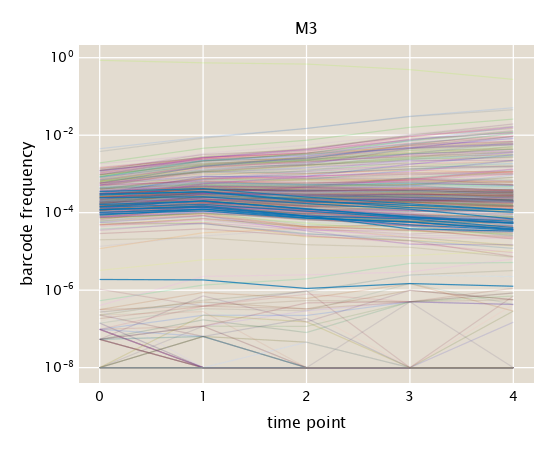

In [27]:
# Define information for data to extract
# Define batch
env = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df_tidy_rep[
    (df_tidy_rep.env.==env).&(df_tidy_rep.rep.==rep),
    :]

# Initialize figure
fig = Figure(resolution=(550, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(env)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time,
        bc.freq .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.15)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time,
        bc.freq .+ 1E-8,
        color=(ColorSchemes.seaborn_colorblind[1], 0.75)
    )
end # for

fig

Recall that we named some of the `M3` replicates as `M3_#` to avoid issues with
replicates number not matching. At this point, our dataframe has the correct
tidy format with the corresponding `T0`. We can therefore change these
environments back to the correct number and adjust the number of replicate.

In [28]:
# Group data by environment and rep
df_group = DF.groupby(
    df_tidy_rep[occursin.("M3_", df_tidy_rep.env), :], [:env, :rep]
)
# Extract keys
df_keys = collect(keys(df_group))

# Find maximum rep for M3
m3_max = parse(
    Int64, maximum(df_tidy_rep[df_tidy_rep.env .== "M3", :rep])[end]
)

# Loop through groups
for (i, group) in enumerate(df_group)
    # Extract env and rep
    env, rep = [df_keys[i]...]

    # Find index of rows to be modified
    idx = (df_tidy_rep.env .== env) .& (df_tidy_rep.rep .== rep)

    # Modify rep
    df_tidy_rep[idx, :rep] .= "R$(m3_max + i)"
    # Modfiy env
    df_tidy_rep[idx, :env] .= "M3"
end # for

Let's finally make sure the number of elements per time point remains the same.
Note: The reason I do this multiple times as an internal control is because it
was an issue to get it to work.

In [29]:
# Group data by environment and replicate
df_group = DF.groupby(df_tidy_rep, [:env, :rep])

# Initialize list to save lengths
len_list = []

# Loop through groups
for data in df_group
    # group data by time
    data_group = DF.groupby(data, :time)

    # Append length to list
    push!(len_list, [size(x, 1) for x in data_group])
end # group

unique(len_list)

2-element Vector{Any}:
 [550, 550, 550, 550, 550]
 [550, 550, 550, 550]

Let's make sure that the only environment left with `M3` is "pure" `M3`.

In [36]:
# List environments with M3 on the name
unique(df_tidy_rep[occursin.("M3", df_tidy_rep.env), :env])

1-element Vector{String}:
 "M3"

Let's look at the replicates associated with M3.

In [37]:
# List replicate numbers associated with M3 environment
unique(df_tidy_rep[occursin.("M3", df_tidy_rep.env), :rep])

25-element Vector{String}:
 "R5"
 "R6"
 "R7"
 "R8"
 "R9"
 "R10"
 "R11"
 "R12"
 "R13"
 "R14"
 ⋮
 "R21"
 "R22"
 "R23"
 "R24"
 "R25"
 "R1"
 "R2"
 "R3"
 "R4"

One more piece of information provided by the authors are the
`condition_categories`. These categories group several conditions into a larger
group such as `glucose`, `salt`, and `drugs`. Here is the list provided by the
authors.

In [38]:
condition_categories = Dict(
    "19" => "M3",
    "M3_Batch_3" => "M3",
    "M3_Batch_6" => "M3",
    "M3_Batch_13" => "M3",
    "M3_Batch_18" => "M3",
    "M3_Batch_20" => "M3",
    "M3_Batch_21" => "M3",
    "M3_Batch_23" => "M3",
    "M3" => "M3", "Baffle" => "glucose",
    "1.4%" => "glucose",
    "1.5%" => "glucose",
    "1.6%" => "glucose",
    "1.7%" => "glucose",
    "1.8%" => "glucose",
    "2.5%" => "glucose",
    "1.4%Gluc" => "glucose",
    "1.8%Gluc" => "glucose", "0.2MNaCl" => "salt",
    "0.5MNaCl" => "salt",
    "0.2MKCl" => "salt",
    "0.5MKCl" => "salt", "8.5uMGdA" => "drugs",
    "17uMGdA" => "drugs",
    "2ugFlu" => "drugs",
    "0.5ugFlu" => "drugs",
    "DMSO" => "drugs",
    "Geldanamycin8.5uM" => "drugs",
    "Ben0.4" => "drugs",
    "Ben2" => "drugs",
    "Ben10" => "drugs", "1%Raf" => "carbons",
    "0.5%Raf" => "carbons",
    "1%Gly" => "carbons",
    "1%EtOH" => "carbons",
    "SucRaf" => "carbons", "Ferm_44hr_Transfer" => "ferm",
    "Ferm_40hr_Transfer" => "ferm",
    "Ferm_54hr_Transfer" => "ferm",
    "Ferm_50hr_Transfer" => "ferm", "Resp_24hr_Transfer" => "resp/stat",
    "Resp_3Day_Transfer" => "resp/stat",
    "Resp_4Day_Transfer" => "resp/stat",
    "Resp_5Day_Transfer" => "resp/stat",
    "Resp_6Day_Transfer" => "resp/stat",
    "Resp_7Day_Transfer" => "resp/stat",
);

Let's map the enviroments to these categories and add a column.

In [39]:
# Add category column
df_tidy_rep[!, :category] = [
    condition_categories[x] for x in df_tidy_rep.env
]

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,count_sum,freq,category
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool,Int64?,Float64,String
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,65807,0.000334311,glucose
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,65807,0.00955825,glucose
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,65807,0.00179312,glucose
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false,65807,0.00797787,glucose
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false,65807,0.00542495,glucose


In [40]:
# Group data by environment and replicate
df_group = DF.groupby(df_tidy_rep, [:env, :rep])

# Initialize list to save lengths
len_list = []

# Loop through groups
for data in df_group
    # group data by time
    data_group = DF.groupby(data, :time)

    # Append length to list
    push!(len_list, [size(x, 1) for x in data_group])
end # group

unique(len_list)

2-element Vector{Any}:
 [550, 550, 550, 550, 550]
 [550, 550, 550, 550]

Done! Let's save the dataframe into a `csv` file.

In [41]:
CSV.write("$(git_root())/data/kinsler_2020/tidy_counts.csv", df_tidy_rep)

"/Users/mrazo/git/bayesian_fitness/data/kinsler_2020/tidy_counts.csv"